In [1]:
# set up some environmental dependencies
import os
import argparse
import numpy as np
import pandas as pd
import astropy.cosmology.units as cu
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from matplotlib.pyplot import *
import seaborn as sns
import numpy as np, matplotlib.pyplot as plt
import warnings
from scipy.stats import truncnorm
os.environ['SPS_HOME'] = "/Users/krittisharma/Desktop/research/fsps"
import sedpy
from tqdm import tqdm
from prospect.fitting import lnprobfn, fit_model
from prospect.plotting.sfh import nonpar_recent_sfr, ratios_to_sfrs
from prospect.plotting import sfh
from prospect.models import priors, sedmodel
from prospect.sources import FastStepBasis
from sedpy import observate
from prospect.models.sedmodel import SedModel, PolySedModel
from prospect.models.templates import TemplateLibrary
from prospect.models import priors
from prospect.models.templates import adjust_continuity_agebins
import prospect.io.read_results as reader
import prospect.io.write_results as writer
warnings.filterwarnings("ignore")

# standard imports for my work
from read_transients_data import *
from helper_functions import *
from sed_analysis_funcs import *

plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['image.origin'] = 'lower'
sns.set_context('talk')
sns.set(font_scale=1.2)
sns.set_palette('colorblind')
sns.set_style('ticks')
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma', 'Verdana', 'Lucida Grande', 'DejaVu Sans']


In [2]:
large_host_sample = read_dsa_data()
frb = "mizu"
use_parametric = "N"
use_spectrum = "Y"
os.chdir("frbs_data/dsa_results/{}".format(frb))
frbs_file = "frb_obs.csv"
frbs_db = pd.read_csv(frbs_file)


In [3]:
mags_raw = []
mags_unc = []
filternames = []

filterset = ['galex_FUV', 'galex_NUV', 'sdss_u0',
             'ps1_g', 'decam_g', 'sdss_g0', 'wasp_g0', 'LRIS_G',
             'ps1_r', 'decam_r', 'sdss_r0', 'wasp_r0', 'LRIS_R', 'DEIMOS_R',
             'ps1_i', 'sdss_i0', 'wasp_i0', 
             'ps1_z', 'decam_z', 'sdss_z0', 'wasp_z0',
             'ps1_y',
             'twomass_J', 'wirc_J', 
             'twomass_H', 'wirc_H', 
             'twomass_Ks', 'wirc_Ks',
             'wise_w1', 'wise_w2', 'wise_w3', 'wise_w4'
             ]
cmap = matplotlib.cm.get_cmap('rainbow')
color_idx = []

for filt in filterset:
    if frbs_db[filt][0] != -99 and frbs_db[filt][0] != -100:
        filternames.append(filt)
        mags_raw.append(frbs_db[filt][0])
        mags_unc.append(float(frbs_db[filt+"_err"][0]))
        color_idx.append(np.where(np.array(filterset) == filt)[0][0])

In [4]:
# store some meta-parameters that control the input arguments to this method
run_params = {}
run_params["zred"] = frbs_db["redshift"][0]

if use_spectrum == "Y":
    run_params["use_spectrum"] = True
    run_params["continuum_order"] = 12
    
    if frbs_db["smooth_spectrum"][0] == "Y":
        run_params["smooth_spectrum"] = True
    else:
        run_params["smooth_spectrum"] = False
    
    if frbs_db["cal_spectrum"][0] == "Y":
        run_params["cal_spectrum"] = True
    else:
        run_params["cal_spectrum"] = False

    if frbs_db["normalize_spectrum"][0] == "Y":
        run_params["normalize_spectrum"] = True
    else:
        print("Normalization of spectrum not possible")
        run_params["normalize_spectrum"] = False

    run_params["norm_band"] = frbs_db["norm_band"][0]
    run_params["add_nebular_emission"] = True
else:
    run_params["use_spectrum"] = False
    run_params["continuum_order"] = 0
    run_params["smooth_spectrum"] = False
    run_params["cal_spectrum"] = False
    run_params["normalize_spectrum"] = False
    run_params["norm_band"] = "ps1_g"
    run_params["add_nebular_emission"] = False

if use_parametric == "Y":
    run_params["use_parametric"] = True
    label = "parametric"
else:
    run_params["use_parametric"] = False
    label = "nonparametric"

run_params["nbins"] = 7

if frbs_db["add_duste"][0] == "Y":
    run_params["add_duste"] = True
else:
    run_params["add_duste"] = False

if frbs_db["add_agn"][0] == "Y":
    run_params["add_agn"] = True
else:
    run_params["add_agn"] = False

run_params["zcontinuous"] = 1
run_params["nwalkers"] = 128
run_params["niter"] = 1024
run_params["nburn"] = [32, 64, 128]
run_params["ldist"] = cosmo.luminosity_distance(run_params["zred"]).value
# luminosity distance to convert apparent magnitudes to observed fluxes
results_type = "dynesty"

xmin, xmax = frbs_db["xmin"][0], frbs_db["xmax"][0]
ymin, ymax = frbs_db["ymin"][0], frbs_db["ymax"][0]


In [5]:
if run_params["use_spectrum"]:
    spectrum_file = frbs_db["spectrum_file"][0]
outfile = "{}.h5".format(frbs_db["frb_name"][0])

# Magnitudes feeded into this pipeline are already corrected for dust
# extinction and AB magnitude system corrections
corrections = np.zeros(np.shape(mags_raw))
phot_mask = [True for i in range(len(mags_raw))]

if run_params["use_spectrum"]:
    if ".spec" in spectrum_file:
        with open(spectrum_file, 'r') as fin:
            data=[]
            for line in fin:
                words = line.split()
                if "#" in words:
                    continue
                elif "##" in words:
                    continue
                else:
                    data.append([float(word) for word in words])
        data = pd.DataFrame(data,
                            columns=["wavelength",  # Angstroms
                                    "flux",  # erg/cm^2/s/Ang
                                    "sky_flux",  # erg/cm^2/s/Ang
                                    "flux_unc",  # erg/cm^2/s/Ang
                                    "xpixel",
                                    "ypixel",
                                    "response",
                                    "flag"]
                            )
        data = data[data["wavelength"]/(1+run_params["zred"]) > 3200].reset_index()
        data = data[data["wavelength"]/(1+run_params["zred"]) < 5200]
        print(data.head())
        
    elif ".dat" in spectrum_file:
        with open(spectrum_file, 'r') as fin:
            data=[]
            for line in fin:
                words = line.split()
                if "#" in words:
                    continue
                elif "##" in words:
                    continue
                else:
                    data.append([float(word) for word in words])
        data = pd.DataFrame(data,
                            columns = ["wavelen", # Angstroms
                                       "flux"]
                           )
        data["flux"]= data["flux"]*(10**-23)/(data["wavelen"]*(data["wavelen"]*10**-8)/(3*10**10))
        data["flux_unc"] = 0.1*data["flux"]
        data["wavelength"] = data["wavelen"]

    else:
        data = pd.read_csv(spectrum_file)
        data["wavelength"] = data["wavelen"]
        data["flux"] = frbs_db["flux_norm"][0]*data["flux"]
        print("Normalized spectrum manually by a factor of {}".format(str(frbs_db["flux_norm"][0])))
        if frbs_db["flux_norm"][0] < 1:
            data["flux_unc"] = frbs_db["flux_norm"][0]*data["flux_unc"]
        else:
            data["flux_unc"] = 0.1*data["flux_unc"]

    print(data.head())
    resolution = 0.8
    wavelen_below = np.arange(xmin, data["wavelength"][0], resolution) 
    wavelen_above = np.arange(list(data["wavelength"])[-1], xmax*(1+run_params["zred"]), resolution)
    wavelens = np.array(list(wavelen_below) +
        list(data["wavelength"])+list(wavelen_above))
    
    fluxes_below = np.zeros(np.shape(wavelen_below))
    fluxes_above = np.zeros(np.shape(wavelen_above))
    fluxes = np.array(list(fluxes_below) +
        list(data["flux"])+list(fluxes_above))

    flux_uncs_below = np.zeros(np.shape(wavelen_below))
    flux_uncs_above = np.zeros(np.shape(wavelen_above))
    flux_uncs = np.array(list(flux_uncs_below) +
        list(data["flux_unc"])+list(flux_uncs_above))

    mask_below = [False for i in range(len(wavelen_below))]
    mask_mid = [True for i in range(len(data))] # list(np.logical_and(data["flux"]/data["flux_unc"]>5, data["flux"]/data["flux_unc"]<40))
    mask_above = [False for i in range(len(wavelen_above))]
    mask = mask_below+mask_mid+mask_above

    data = pd.DataFrame({"wavelen": wavelens,
                        "flux": fluxes,
                        "flux_unc": flux_uncs,
                        "mask": mask})

    wavelen = np.asarray(data["wavelen"], dtype="float")
    flux = np.asarray(data["flux"]*(10**23)*data["wavelen"] *
                      (data["wavelen"]*10**-8)/((3*10**10)*3631),
                      dtype="float")
    flux_unc = np.asarray(data["flux_unc"]*(10**23)*data["wavelen"] *
                          (data["wavelen"]*10**-8)/((3*10**10)*3631),
                          dtype="float")
    mask = data["mask"]

else:
    wavelen = None
    flux = None
    flux_unc = None
    mask = None


Normalized spectrum manually by a factor of 1.0
   Unnamed: 0  index      wavelen          flux      flux_unc  wavelen_rest  \
0           0   1463  4356.368532  1.253290e-16  5.018050e-19   4200.933975   
1           1   1464  4357.404000  1.253844e-16  5.041250e-19   4201.932498   
2           2   1465  4358.439715  1.255640e-16  5.084570e-19   4202.931259   
3           3   1466  4359.475676  1.257191e-16  5.109170e-19   4203.930257   
4           4   1467  4360.511883  1.267180e-16  5.151730e-19   4204.929492   

    wavelength  
0  4356.368532  
1  4357.404000  
2  4358.439715  
3  4359.475676  
4  4360.511883  


In [6]:
obs = build_obs(filternames=filternames,
                mags_raw=np.array(mags_raw),
                mags_unc=np.array(mags_unc),
                corrections=corrections,
                phot_mask=phot_mask,
                wavelen=wavelen,
                flux=flux,
                flux_unc=flux_unc,
                mask=mask,
                **run_params)

wphot = obs["phot_wave"]

model = build_model(**run_params)
sps = build_sps(**run_params)


In [7]:
a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# spectroscopic wavelengths
if obs["wavelength"] is None:
    wspec = sps.wavelengths
    wspec *= a  # redshift them
else:
    wspec = obs["wavelength"]

result, _, _ = reader.results_from(outfile, dangerous=False)
weights = result.get('weights', None)

imax = np.argmax(result['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    thin = 6
else:
    theta_max = result["chain"][imax, :]
    thin = 1

print('MAP value: {}'.format(theta_max))

pspec_map, pphot_map, pfrac_map = model.mean_model(theta_max,
                                                obs=obs,
                                                sps=sps)


MAP value: [ 3.60937317e-02  6.51926256e-01  3.93229118e-01 -2.07799063e-01
  2.18831959e-02 -3.04587408e-01 -6.92626618e-01  1.33763439e-01
  1.06342565e+01 -1.12532777e+00 -8.89044763e-01  7.87056909e-01
  1.28705952e+02  6.62607742e-01  1.60782093e-02  1.01785215e+02
  3.60422447e-01 -3.00361620e+00  8.91381630e+01  3.17194483e+02
  4.99966235e-01  1.21962056e+00]


In [8]:
obs["unc"] = 10*obs["unc"]
ymax = 3e-5

Text(6725.67, 5.6e-06, '[S II]')

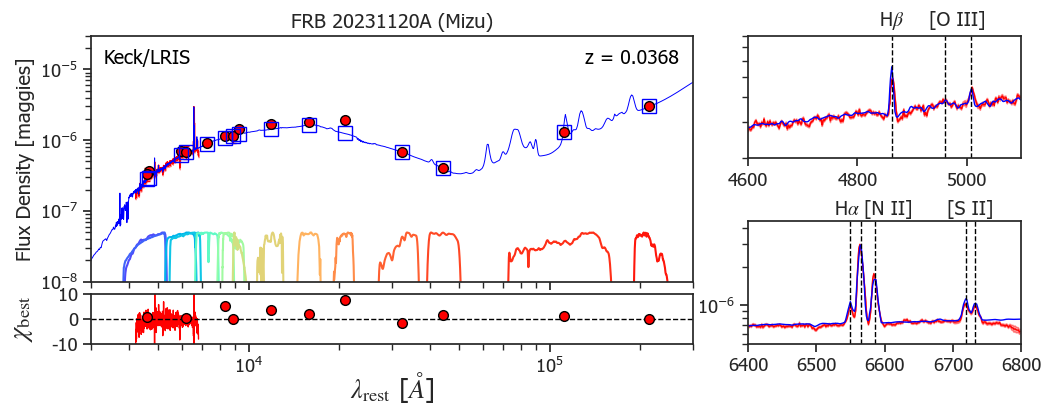

In [9]:
fig = plt.figure(figsize=(12, 4))
grid = plt.GridSpec(30, 6, wspace=0.5, hspace=0.2)
ax = plt.subplot(grid[:24, :4])
ax1 = plt.subplot(grid[25:, :4])
ax2 = plt.subplot(grid[:12, 4:])
ax3 = plt.subplot(grid[18:, 4:])

# Compute maximum posterior probability model
pspec_map, pphot_map, _ = model.mean_model(theta_max,
                                                obs=obs,
                                                sps=sps)

# Plot observed and maximum posterior probability photometry
ax.errorbar(wphot/(1+theta_max[0]),
            obs['maggies'],
            yerr=obs['maggies_unc'],
            ecolor='red', fmt="o",  capsize=2,  elinewidth=1,
            markersize=7, markerfacecolor='red', markeredgecolor='black', markeredgewidth=1)
ax.errorbar(wphot/(1+theta_max[0]),
            pphot_map,
            marker='s', markersize=10, ls='', lw=1,
            markerfacecolor='none', markeredgecolor='blue', markeredgewidth=1)

# Plot observed and maximum posterior probability spectroscopy
if run_params["use_spectrum"]:
    if run_params["cal_spectrum"]:
        ax.plot(obs["wavelength"][np.nonzero(np.asarray(obs["mask"]))]/(1+theta_max[0]),
            obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))] /
            np.interp(wspec[np.nonzero(np.asarray(obs["mask"]))],
                    wspec,
                    model._speccal),
            linestyle='solid', lw=1, color='red')
        ax.fill_between(obs["wavelength"][np.nonzero(np.asarray(obs["mask"]))]/(1+theta_max[0]), 
            (obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))] /
            np.interp(wspec[np.nonzero(np.asarray(obs["mask"]))],
                    wspec,
                    model._speccal)-obs["unc"][np.nonzero(np.asarray(obs["mask"]))]), 
            (obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))] /
            np.interp(wspec[np.nonzero(np.asarray(obs["mask"]))],
                    wspec,
                    model._speccal)+obs["unc"][np.nonzero(np.asarray(obs["mask"]))]),
            color="red", alpha=0.4)
    else:
        ax.plot(obs["wavelength"][np.nonzero(np.asarray(obs["mask"]))]/(1+theta_max[0]),
            obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))],
            linestyle='solid', lw=1, color='red')
        ax.fill_between(obs["wavelength"][np.nonzero(np.asarray(obs["mask"]))]/(1+theta_max[0]), 
            (obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))]-obs["unc"][np.nonzero(np.asarray(obs["mask"]))]), 
            (obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))]+obs["unc"][np.nonzero(np.asarray(obs["mask"]))]),
            color="red", alpha=0.4)

if run_params["cal_spectrum"]:
    ax.loglog(wspec/(1+theta_max[0]),
        pspec_map/model._speccal,
        lw=0.7, color='blue', alpha=1)
else:
    ax.loglog(wspec/(1+theta_max[0]),
        pspec_map,
        lw=0.7, color='blue', alpha=1)

# Plot transmission curves
for i in range(len(obs['filters'])):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t*ymin
    ax.plot(w/(1+theta_max[0]), t, lw=1.5, 
            color=cmap(color_idx[i]/len(filterset)), 
            alpha=1)
    
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_ylabel('Flux Density [maggies]')
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_title('{} ({}{})'.format(large_host_sample[large_host_sample["frb_name"]==frb].reset_index()["FRB_TNS_name"][0], 
                                frb[0].upper(), 
                                frb[1:]))
ax.text(.02, .91, large_host_sample[large_host_sample["frb_name"]==frb].reset_index()["instrument"][0], 
        color="black", ha='left', va='center', transform=ax.transAxes, size=14)
ax.text(.82, .91, 'z = {}'.format(round(float(large_host_sample[large_host_sample["frb_name"]==frb].reset_index()["redshift"][0]), 4)), 
        color="black", ha='left', va='center', transform=ax.transAxes, size=14)


##############################################################################################################################
##############################################################################################################################
##############################################################################################################################


if run_params["use_spectrum"]:
    if run_params["cal_spectrum"]:
        ax1.plot(obs["wavelength"][np.nonzero(np.asarray(obs["mask"]))]/(1+theta_max[0]),
                 -((pspec_map[np.nonzero(np.asarray(obs["mask"]))]/
                    model._speccal[np.nonzero(np.asarray(obs["mask"]))]) - (obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))]/
                    np.interp(wspec[np.nonzero(np.asarray(obs["mask"]))],
                              wspec,
                              model._speccal)))/(obs["unc"][np.nonzero(np.asarray(obs["mask"]))]),
                 lw=1, color='red', alpha=1)
    else:
        ax1.plot(obs["wavelength"][np.nonzero(np.asarray(obs["mask"]))]/(1+theta_max[0]),
                 -((pspec_map[np.nonzero(np.asarray(obs["mask"]))]) - (obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))]))/(obs["unc"][np.nonzero(np.asarray(obs["mask"]))]),
                 lw=1, color='red', alpha=1)
        
ax1.errorbar(wphot/(1+theta_max[0]),
             -(pphot_map-obs['maggies'])/obs['maggies_unc'],
             ecolor='red', fmt="o",  capsize=2,  elinewidth=0.5, 
             markersize=7, markerfacecolor='red', markeredgecolor='black', markeredgewidth=1)

ax1.set_xlabel(r'$\lambda_{{\mathrm{rest}}}$ [$\AA$]', fontsize=19, labelpad=-5)
ax1.set_ylabel(r'$\chi_{{\mathrm{best}}}$', labelpad=12, fontsize=19)
ax1.axhline(0, linestyle="--", color="black", linewidth=1)

ax1.set_xscale("log")
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([-10, 10])


##############################################################################################################################
##############################################################################################################################
##############################################################################################################################

if run_params["use_spectrum"]:
    if run_params["cal_spectrum"]:
        ax2.plot(obs["wavelength"][np.nonzero(np.asarray(obs["mask"]))]/(1+theta_max[0]),
                 obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))] /
                 np.interp(wspec[np.nonzero(np.asarray(obs["mask"]))],
                           wspec,
                           model._speccal),
                 alpha=1, linestyle='solid', lw=1, color='red')
        ax2.fill_between(obs["wavelength"][np.nonzero(np.asarray(obs["mask"]))]/(1+theta_max[0]), 
                         (obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))] /
                          np.interp(wspec[np.nonzero(np.asarray(obs["mask"]))],
                                    wspec,
                                    model._speccal)-obs["unc"][np.nonzero(np.asarray(obs["mask"]))]), 
                        (obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))] /
                         np.interp(wspec[np.nonzero(np.asarray(obs["mask"]))],
                                   wspec,
                                   model._speccal)+obs["unc"][np.nonzero(np.asarray(obs["mask"]))]),
                         color="red", alpha=0.4)
    else:
        ax2.plot(obs["wavelength"][np.nonzero(np.asarray(obs["mask"]))]/(1+theta_max[0]),
                 obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))],
                 alpha=1, linestyle='solid', lw=1, color='red')
        ax2.fill_between(obs["wavelength"][np.nonzero(np.asarray(obs["mask"]))]/(1+theta_max[0]), 
                         (obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))]-obs["unc"][np.nonzero(np.asarray(obs["mask"]))]), 
                         (obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))]+obs["unc"][np.nonzero(np.asarray(obs["mask"]))]),
                         color="red", alpha=0.4)

if run_params["cal_spectrum"]:
    ax2.plot(wspec/(1+theta_max[0]),
             pspec_map/model._speccal,
             lw=1,
             color='blue',
             alpha=1)
else:
    ax2.plot(wspec/(1+theta_max[0]),
             pspec_map,
             lw=0.7,
             color='blue',
             alpha=0.7)
    
ax2.set_xlim([4600, 5100])
ax2.set_ylim([2e-7, 8e-7])
ax2.set_yscale("log")

ax2.axvline(4862.68, color="black", linestyle = "--", linewidth = 1)
ax2.text(4862.68, 9.5e-7, r'H$\beta$', ha='center', va='center', size=14)

# ax2.axvline(4932.603, color="black", linestyle = "--", linewidth = 1)
ax2.text(4932.603+50, 9.5e-7, '[O III]', ha='center', va='center', size=14)
ax2.axvline(4960.295, color="black", linestyle = "--", linewidth = 1)
ax2.axvline(5008.240, color="black", linestyle = "--", linewidth = 1)

##############################################################################################################################
##############################################################################################################################
##############################################################################################################################

if run_params["use_spectrum"]:
    if run_params["cal_spectrum"]:
        ax3.plot(obs["wavelength"][np.nonzero(np.asarray(obs["mask"]))]/(1+theta_max[0]),
                 obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))] /
                 np.interp(wspec[np.nonzero(np.asarray(obs["mask"]))],
                           wspec,
                           model._speccal),
                 alpha=1, linestyle='solid', lw=1, color='red')
        ax3.fill_between(obs["wavelength"][np.nonzero(np.asarray(obs["mask"]))]/(1+theta_max[0]), 
                         (obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))] /
                          np.interp(wspec[np.nonzero(np.asarray(obs["mask"]))],
                                    wspec,
                                    model._speccal)-obs["unc"][np.nonzero(np.asarray(obs["mask"]))]), 
                        (obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))] /
                         np.interp(wspec[np.nonzero(np.asarray(obs["mask"]))],
                                   wspec,
                                   model._speccal)+obs["unc"][np.nonzero(np.asarray(obs["mask"]))]),
                         color="red", alpha=0.4)
    else:
        ax3.plot(obs["wavelength"][np.nonzero(np.asarray(obs["mask"]))]/(1+theta_max[0]),
                 obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))],
                 alpha=1, linestyle='solid', lw=1, color='red')
        ax3.fill_between(obs["wavelength"][np.nonzero(np.asarray(obs["mask"]))]/(1+theta_max[0]), 
                         (obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))]-obs["unc"][np.nonzero(np.asarray(obs["mask"]))]), 
                         (obs['spectrum'][np.nonzero(np.asarray(obs["mask"]))]+obs["unc"][np.nonzero(np.asarray(obs["mask"]))]),
                         color="red", alpha=0.4)

if run_params["cal_spectrum"]:
    ax3.plot(wspec/(1+theta_max[0]),
             pspec_map/model._speccal,
             lw=1,
             color='blue',
             alpha=1)
else:
    ax3.plot(wspec/(1+theta_max[0]),
             pspec_map,
             lw=0.7,
             color='blue',
             alpha=0.7)
    
ax3.set_xlim([6400, 6800])
ax3.set_ylim([5e-7, 4.5e-6])
ax3.set_yscale("log")
ax2.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax3.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax3.axvline(6564.61, color="black", linestyle = "--", linewidth = 1)
ax3.text(6564.61-20, 5.6e-6, r'H$\alpha$', ha='center', va='center', size=14)

ax3.axvline(6549.86, color="black", linestyle = "--", linewidth = 1)
ax3.axvline(6585.27, color="black", linestyle = "--", linewidth = 1)
ax3.text(6585.27+20, 5.6e-6, '[N II]', ha='center', va='center', size=14)

ax3.axvline(6718.29, color="black", linestyle = "--", linewidth = 1)
ax3.axvline(6732.67, color="black", linestyle = "--", linewidth = 1)
ax3.text(6732.67-7, 5.6e-6, '[S II]', ha='center', va='center', size=14)

